In [1]:
# Import os package for interface with the operating system
import os

# General purpose imports to handle files, visualizations etc
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Import util.py with the FlankerTest class
execfile('utils.py')

# Acquire data

In [2]:
'''
Data available at https://openneuro.org/datasets/ds000102/versions/00001
'''

#List of subjects
subjects = [FlankerTest('sub-01'), FlankerTest('sub-02'), FlankerTest('sub-03')]


#Download files and format according to BIDS standard
for sub in subjects:
    sub.download_open_neuro(anat=True, func=True)


# Part-1: Visualising data

In this part we focus on "sub-01" only.

### Static visualization

In [3]:
reset_overlays()

#Flag to display type of MRI image
display_type = 'func'

if display_type == 'anat':
    load(op.join(subjects[0].ANAT_PATH, subjects[0].subject+'_T1w.nii.gz'));
elif display_type == 'func':
    load(op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold.nii.gz'));
    load(op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-2_bold.nii.gz'));
    


<center><img src="images/static_visualization.png"/>
    <p style="text-align:center;"><i>Static visualization of the anatomical data (left) and run-1 of the functional data (rigth)</i></p></center>

### Animation

Here we create a .gif animation of the MRI images

In [4]:
#Animate anatomical data
animate_input=op.join(subjects[0].ANAT_PATH, subjects[0].subject+'_T1w.nii.gz')
animate_output=op.join(subjects[0].DER_ANAT_PATH, subjects[0].subject+'_animation.gif')

cmd='fslanimate {} {}'.format(animate_input, animate_output)

os.system(cmd);


<center><img src="images/sub-01_animation.gif"/>
    <p style="text-align:center;"><i>Animation over different slices</i></p></center>

In [6]:
#Animate functional data (run-1)
animate_input=op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold.nii.gz')
animate_output=op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_run-1_animation.gif')

cmd='fslanimate {} {}'.format(animate_input, animate_output)

os.system(cmd);

<center><img src="images/sub-01_run-1_animation.gif"/>
    <p style="text-align:center;"><i>Animation over different volumes</i></p></center>

# Part-2: Brain extraction

We still focus on "sub-01" and extend the analysis by extracting the brain for different fractional intensity threshold

In [5]:
bet_input = op.join(subjects[0].ANAT_PATH, subjects[0].subject+'_T1w.nii.gz')
bet_output = op.join(subjects[0].DER_ANAT_PATH, subjects[0].subject+'_T1w_BET')

#Define different fractial intensities values
f_intensities = [0.25, 0.5, 0.75, 1]
for f in f_intensities:
    bet(bet_input, bet_output+'_f'+str(f)+'.nii.gz', robust=True, fracintensity=f)

In [7]:
reset_overlays()

load(bet_input)
for f in f_intensities:
    load(bet_output+'_f'+str(f)+'.nii.gz')

<center><img src="images/bet_skull.png"/>
    <p style="text-align:center;"><i>Notice that the skull trimming increases for greater fractional intensities. The figure indicates the different level of fractional intensity values. That we have in increasing order: pink (f=0.25), yellow (f=0.5), red (f=0.75) and green (f=1). f=fractional intensity</i></p></center>

# Part-3: Motion correction

In this section we compute and analyze the motion correction on "sub-01". We then compare the results to two other subjects (i.e. "sub-02" and "sub-03"). For all subjects we consider run-1 only.

### Motion correction

After inspecting the fMRI data, no garbage volumes has been found. That is, there seem to be no faulty volumes to the field stabilization. Hence, we can perform motion correction on all the provided volumes.

In [8]:
moco_input=op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold.nii.gz')
moco_output=op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco') 
ref_vol = op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco_ref.nii.gz')

#First extract reference volume (volume 40 in this case)
fslroi(moco_input, ref_vol, str(40), str(1));

#Apply motion correction
mcflirt(infile=moco_input, o=moco_output, refvol=ref_vol, plots=True, report=True, dof=6, mats=True);


In [9]:
#Quality control of framewise displacement
reset_overlays()

load(moco_input);
load(moco_output);

<center><img src="images/sub-01_run-1_moco_animation.gif"/>
    <p style="text-align:center;"><i>Functional data after motion correction</i></p></center>

### Framewise displacement

In [10]:
#Motion parameters
mot_params = op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco.par')

#Compute framewise displacement 
fd = subjects[0].framewise_displacement(mot_params).to_numpy()

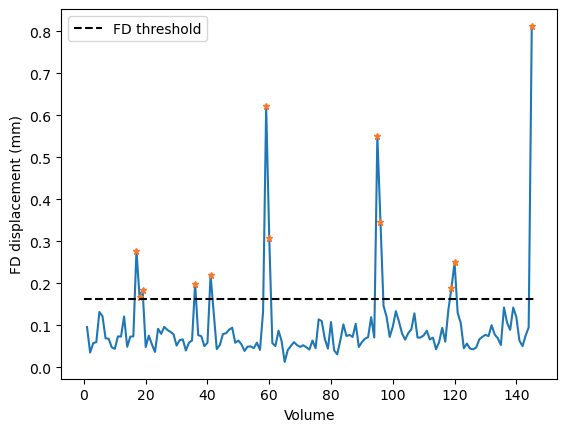

In [11]:
#Visualize framewise displacement
threshold = np.quantile(fd, 0.75)+1.5*(np.quantile(fd, 0.75)-np.quantile(fd, 0.25))
#Find at which volumes the threshold is exceeded
outliers = np.where(fd > threshold)[0]+1

#Plot framewise displacement
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(list(range(1, fd.size+1)), fd);
ax.plot(outliers, fd[outliers-1], color=(247/255, 122/255, 45/255), linestyle="", marker="*", markersize=5)
ax.set_xlabel('Volume');
ax.set_ylabel('FD displacement (mm)');
ax.hlines(threshold, 0, fd.size+1,colors='black', linestyles='dashed', label='FD threshold');
ax.legend();

### Voxel timeseries

In [12]:
#Extract data before motion correction and convert to numpy array
original_data = nib.load(op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold.nii.gz'))
original_data_np = original_data.get_fdata()
#Extract data after motion correction and convert to numpy array
moco_data = nib.load(op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco.nii.gz'))
moco_data_np = moco_data.get_fdata()

```python
fig, ax = plt.subplots(3,1, sharex=True, figsize=(7,7))
fig.tight_layout(h_pad=5.0)
fig.text(-0.05, 0.5, 'Intensity (a.u.)', va='center', rotation='vertical', fontsize=11);

voxels = [(5, 31, 19), (10, 31, 19), (31, 31, 19)]

for i, voxel in enumerate(voxels):
    
    #Unpack coordinates
    x, y, z = voxel
    
    #Plot time series of voxel
    ax[i].plot(original_data_np[x, y, z, :], label="Original");
    ax[i].plot(moco_data_np[x, y, z, :], label="Moco");
    
    ax[i].set_title('Voxel at ({}, {}, {})'.format(x,y,z));
    ax[i].set_xlabel('Volume');
    ax[i].legend(loc=(1.02, 0.7));
```


<center><img src="images/voxel_timeseries.png"/>
    <p style="text-align:center;"><i>Here three distinct voxels are displayed. The plots on the left show the intensity timeseries. The transverse brain slice on the right indicate the location of the voxels respectively. Original data (blue) corresponds to the functional data before motion correction. Moco (blue) corresponds to the functional data after motion correction.</i></p></center>

We observe the following:
* **Voxel (5, 31, 19)**: This voxel is picked outside the brain region and thus shows the timeseries of the background signal. For that reason we see no obvious difference between the timeseries before and after motion correction.
* **Voxel (10, 31, 19)**: This voxel is picked on the brain-background boundary. We expected that motion correction has more impact on this region as the intensity values here are most sensitive to affine transformation due to the high contrast. As can be observed, we indeed see a larger difference between the original and moco timeseries, according to our expectation.
* **Voxel (31, 31, 10)**: The final voxel is in the center of the transverse brain slice. We observe the difference between the original and moco signal is between the two previous voxel coordinates. This makes sense as we aimed to pick the two extreme cases previously. However, as the contrast is relatively high here as well, the resulting timeseries leans towards the brain-background boundary case.

To show this claim that voxels at the periphery of the brain are more sensitive to motion, the following will be done:

- Extract the temporal mean of the mean absolute difference between the original data and the motion corrected data
- Plot the histogram distribution of the latter and define a threshold
- Based on the threshold, mask the voxels that exceed this defined value
- Visualize in FSL

Hence, we expect to find the masked voxels to be around the location where the contrast is high. That is, around the periphery of the brain and the anterior-posterior axis through voxel (10, 31, 19). Let's do this!

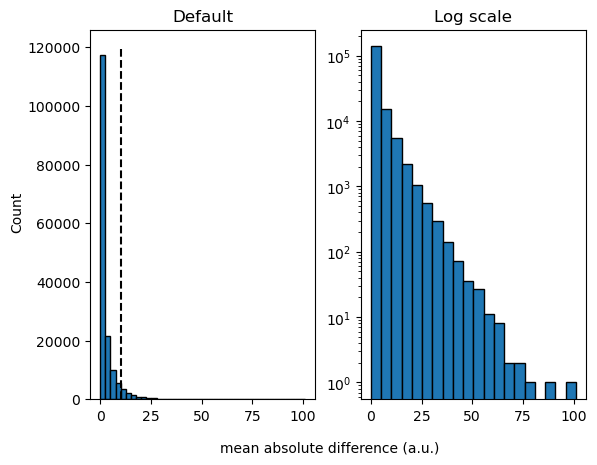

In [13]:
#Compute temporal mean intensity difference per voxel
mean_abs_diff = np.mean(np.absolute(original_data_np-moco_data_np), axis=3)

#Visualize distribution in histogram
fig, ax = plt.subplots(1,2, sharex=True);

ax[0].hist(mean_abs_diff.ravel(), bins=40, edgecolor='k');
ax[0].vlines(10, 0, 120000,colors='black', linestyles='dashed', label='Threshold'); #Threshold
ax[1].hist(mean_abs_diff.ravel(), bins=20, edgecolor='k', log=True);

ax[0].set_title('Default')
ax[1].set_title('Log scale')
fig.text(0.5, 0, 'mean absolute difference (a.u.)', ha='center');
fig.text(0, 0.5, 'Count', va='center', rotation='vertical');

As observed, the histogram follows a exponential distribution (i.e. see linear relationship for the log scale). The bulk has a small mean absolute difference, corresponding to the background signal. Based on the histogram we define a threshold of mean absolute differce to be at 10. Now let's visualize this.

In [14]:
#Tile mean_abs_diff to match dimensions of original data
mean_abs_diff = np.tile(np.expand_dims(mean_abs_diff, axis=3), (1,1,1, original_data_np.shape[3]))

#Define threshold based on histogram
hist_threshold = 10

#Apply threshold
original_data_np[mean_abs_diff<hist_threshold] = 0

#Convert to nifti image
original_data_masked = nib.Nifti1Image(original_data_np, original_data.affine, original_data.header)

#save image
nib.save(original_data_masked, op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_masked_voxels.nii.gz'))

#Quality control check of the temporal mean
reset_overlays()

In [15]:
#Quality control
reset_overlays()

#load original data
load(op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold.nii.gz'));

#load masked data
load(op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_masked_voxels.nii.gz'));

<center><img src="images/thresholding.png"/>
    <p style="text-align:center;"><i>Notice that the skull trimming extends upon greater fractional intensities values (indicated by the darker shade)</i></p></center>

### Bonus

Here we will repeat the process for motion correction, however instead of using a single volume as reference we now take a temporal average of all the volumes. In addition, we will compare the results of "sub-01" with the two other subjects: "sub-02" and "sub-03"

In [16]:
#Create temporal average using fslmaths's Tmean

input_file = op.join(subjects[0].FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold.nii.gz')
output_file = op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_tmean.nii.gz')

cmd = "fslmaths {} -Tmean {}".format(input_file, output_file)

os.system(cmd);

In [17]:
#Quality control check of the temporal mean
reset_overlays()

load(input_file);
load(output_file);

<center><img src="images/fMRI_Tmean.png" width=500/>
    <p style="text-align:center;"><i>Temporal average of the functional data</i></p></center>

Now that we confirmed that the temporal average volume looks good, we can move on to apply the motion correction

In [18]:
#Apply motion correction using the temporal mean as reference volume

moco_Tmean_output = op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco_Tmean')

mcflirt(infile=input_file, o=moco_Tmean_output, refvol=output_file, plots=True, report=True, dof=6, mats=True);

Let's repeat the same procedure for "sub-02" and "sub-03"

In [19]:
#Create temporal mean for "sub-02" and "sub-03" succesively

for sub in subjects[1:]:

    cmd = "fslmaths {} -Tmean {}".format(op.join(sub.FUNC_PATH, sub.subject+'_task-flanker_run-1_bold.nii.gz'), 
                                         op.join(sub.DER_FUNC_PATH, sub.subject+'_task-flanker_run-1_bold_tmean.nii.gz'))

    os.system(cmd);
    

In [20]:
#Quality control on "sub-02" and "sub-03"
reset_overlays()

for sub in subjects[1:]:
    load(op.join(sub.FUNC_PATH, sub.subject+'_task-flanker_run-1_bold.nii.gz'));
    load(op.join(sub.DER_FUNC_PATH, sub.subject+'_task-flanker_run-1_bold_tmean.nii.gz'));
    

For both "sub-02" and "sub-03" we do not see abnormal volumes due to field stabilization. Hence, we can continue with the analysis and perform the motion correction.

In [21]:
#Apply motion correction using the temporal mean as reference volume
for sub in subjects[1:]:

    mcflirt(infile=op.join(sub.FUNC_PATH, sub.subject+'_task-flanker_run-1_bold.nii.gz'),
            o=op.join(sub.DER_FUNC_PATH, sub.subject+'_task-flanker_run-1_bold_moco_Tmean'),
            refvol=op.join(sub.DER_FUNC_PATH, sub.subject+'_task-flanker_run-1_bold_tmean.nii.gz'),
            plots=True, report=True, dof=6, mats=True);
    
    

We are now ready to compare the framewise displacement between the three subjects!

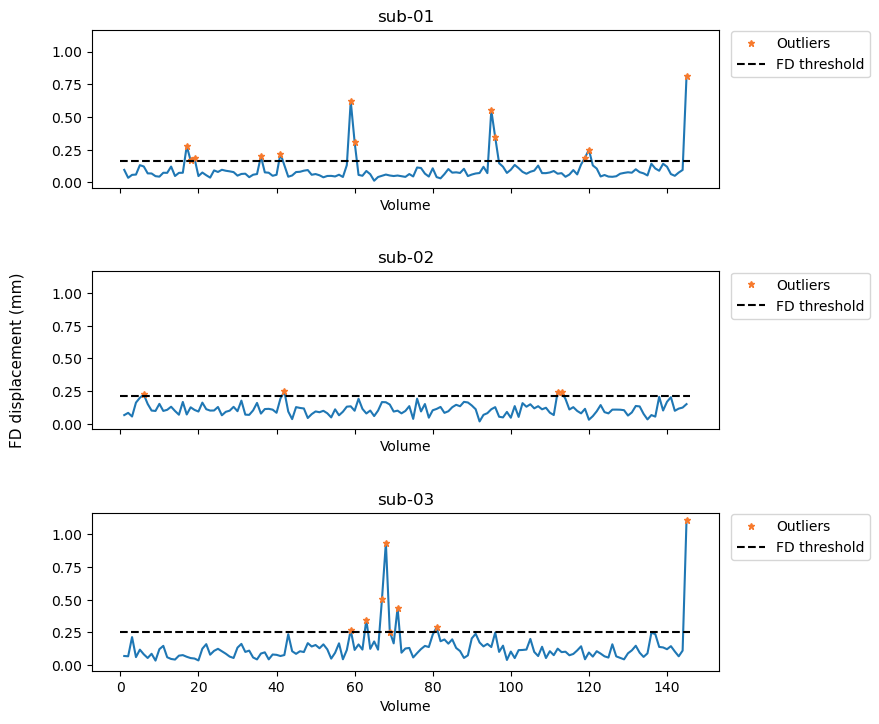

In [22]:
fig, ax = plt.subplots(len(subjects), 1, sharey=True, sharex=True, figsize=(7,7))
fig.tight_layout(h_pad=5.0);
fig.text(-0.05, 0.5, 'FD displacement (mm)', va='center', rotation='vertical', fontsize=11);

for i, sub in enumerate(subjects):
    
    #Motion parameters
    mot_params = op.join(sub.DER_FUNC_PATH, sub.subject+'_task-flanker_run-1_bold_moco_Tmean.par')

    #Compute framewise displacement 
    fd = sub.framewise_displacement(mot_params).to_numpy()

    #Compute threshold
    threshold = np.quantile(fd, 0.75)+1.5*(np.quantile(fd, 0.75)-np.quantile(fd, 0.25))
    
    #Find at which volumes the threshold is exceeded
    outliers = np.where(fd > threshold)[0]+1

    #Plot framewise displacement
    ax[i].plot(list(range(1, fd.size+1)), fd);
    ax[i].plot(outliers, fd[outliers-1], color=(247/255, 122/255, 45/255), linestyle="", marker="*", markersize=5, label="Outliers")
    ax[i].set_title(sub.subject)
    ax[i].set_xlabel('Volume');
    ax[i].hlines(threshold, 0, fd.size+1,colors='black', linestyles='dashed', label='FD threshold');
    ax[i].legend(loc=(1.02, 0.7));

We observe the following:

* **sub-01**: A comparison beteen the motion correction for different reference volumes (i.e. single volume or temporal average) does not reveal compelling differences. This suggests that the fMRI data was already in a good shape and hence having a single volume or temporal average as reference is nearly indifferent.
* **Intersubject comparison**: Comparing the different FD plots reveals nicely the variability in motion between the different subjects. We observe that sub-02 was relatively still compared to the others. Moreover, sub-03 seems to have a period between volumes 60-80 where high motion was present, whereas the motion in sub-01 is more spread out. 

# Part-4: Outlier volumes detection

We now turn back to our original data again (i.e. "sub-01") and detect the volumes with large motion through another metric, called DVARS (D referring to temporal derivative of timecourses, VARS referring to root-mean-square variance over voxels). DVARS is computed by:

$$
DVARS(\Delta I)_{i} = \sqrt{\bigl \langle[ \Delta I_{i}(\overrightarrow{x})]^{2}\bigr \rangle} = \sqrt{\bigl \langle[I_{i}(\overrightarrow{x})-I_{i-1}(\overrightarrow{x})]^{2}\bigr \rangle} 
$$

where $ I_{i}(\overrightarrow{x}) $ is image intensity at coordinate $ \overrightarrow{x} $ on frame $ i $ and angle brackets denote the spatial average over the whole brain.

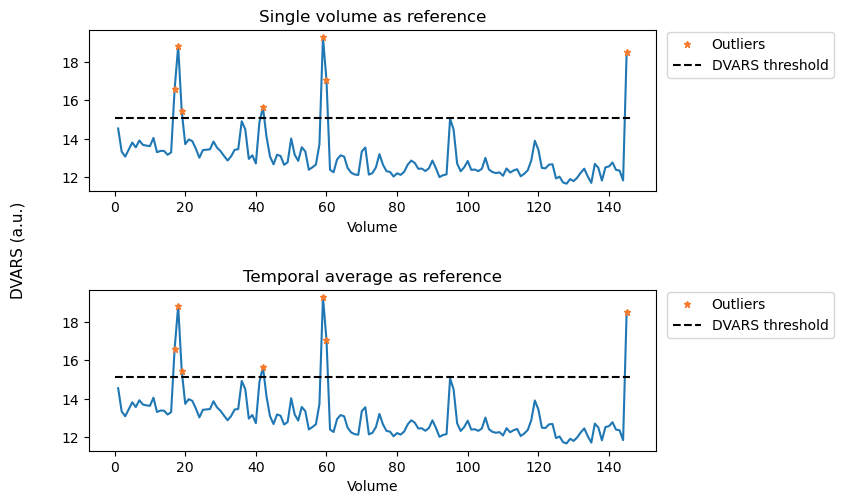

In [23]:
#Paths to moco data of both single volume and tmeporal average files
paths = [op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco.nii.gz'),
         op.join(subjects[0].DER_FUNC_PATH, subjects[0].subject+'_task-flanker_run-1_bold_moco_Tmean.nii.gz')]

#Visualiz DVARS
fig, ax = plt.subplots(len(paths), 1)
fig.tight_layout(h_pad=5.0);
fig.text(-0.05, 0.5, 'DVARS (a.u.)', va='center', rotation='vertical', fontsize=11);
ax[0].set_title('Single volume as reference')
ax[1].set_title('Temporal average as reference')

for i, path in enumerate(paths):
    
    #Compute dvars
    dvars = subjects[0].compute_DVARS(path)
    
    #Compute threshold
    threshold_dvars = np.quantile(dvars, 0.75) + 1.5*(np.quantile(dvars, 0.75)-np.quantile(dvars, 0.25))
    
    #Find at which volumes the threshold is exceeded
    outliers = np.where(dvars > threshold_dvars)[0]+1
    
    #Plot framewise displacement
    ax[i].plot(list(range(1, dvars.size+1)), dvars);
    ax[i].plot(outliers, dvars[outliers-1], color=(247/255, 122/255, 45/255), linestyle="", marker="*", markersize=5, label="Outliers")
    ax[i].set_xlabel('Volume');
    ax[i].hlines(threshold_dvars, 0, fd.size+1,colors='black', linestyles='dashed', label='DVARS threshold');
    ax[i].legend(loc=(1.02, 0.7));

We observe the following:
* **Single volume vs. temporal average**: Similar to the framewise displacement metric, we observe that the motion measure is nearly indifferent for the two different reference images.
* **DVARS vs. Framewise displacement**: Comparing both metrics we observe similar results. This makes sense as they are both correlated. This is because movement of a subject impacts the magnetic field and thus the intensity values measured. As DVARS is a measure of the variance of intensity values, it implicitly measures motion of the subject.

### END OF NOTEBOOK